In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations as comb
from sklearn.neighbors import NearestNeighbors

from tools.data_loading import get_lincs
from tools.metrics import primary_dists, get_consistency

# Data Loading

In [2]:
lincs, lincs_genes, cell_lines = get_lincs()

Pulling folder parsed/literature_datasets/L1000
Pulling folder parsed/proteins


In [3]:
lincs.shape # num KOs X num transcripts X num cell lines

(5002, 978, 9)

### Creating a Null
In order to compare the following experiments with something, within each cell line i'll create a random effect null model by shuffling the rows in each cell line (handling cell lines independently).

In [4]:
lincs_shuffled = np.copy(lincs)
for cell_line in np.arange(lincs.shape[-1]):
    order = np.arange(lincs.shape[0])
    np.random.shuffle(order)
    lincs_shuffled[:,:,cell_line] = lincs[order,:,cell_line] 

## Distance Calculations

For the purposes of this notebook we're just gonna look at L2 distance on unfiltered LINCS data. It's a baseline to compare other strategies to.

In [5]:
metric = 'euclidean'
dists= {'real':primary_dists(lincs, metric = metric),
        'shuffled':primary_dists(lincs_shuffled, metric = metric)}

## Correlation of inter-KO distances across cell line pairs

In [6]:
r2s = {'real':[], 'shuffled':[]}
idxs = np.triu_indices(dists['real'].shape[-1],1)
for cpair in comb(np.arange(dists['real'].shape[0]),2):
    for key in dists:
        r2s[key].append(np.corrcoef(dists[key][cpair[0],:,:][idxs], dists[key][cpair[1],:,:][idxs])[0,1])

[Text(1, 0, 'Real'), Text(2, 0, 'Shuffled')]

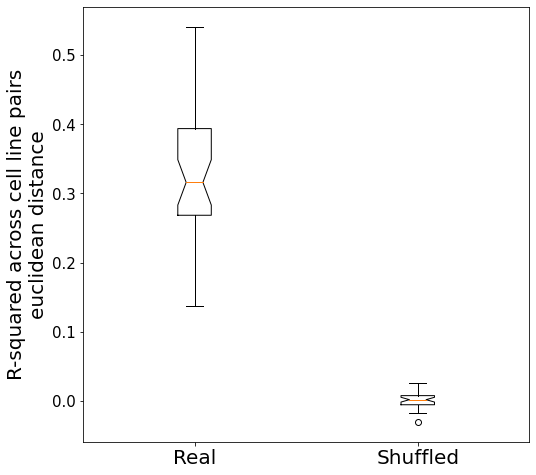

In [7]:
fig, ax = plt.subplots(1, figsize = (8,8))
ax.boxplot([r2s['real'],r2s['shuffled']], notch = True)
ax.set_ylabel(f"R-squared across cell line pairs\n{metric} distance",size = 20)
ax.tick_params(labelsize = 15)
ax.set_xticklabels(['Real','Shuffled'], size = 20)

## Distribution of Median-across-cell-lines-L2 distances 

We'd like to see how much consistent signal there is in the LINCS dataset. One interpretation of this would be that we'd like to observe some set of KO pairs which are consistently close - or at least closer than we would expect by random chance.

I'll therefore look at the median L2 distances across cell lines for each KO pair and compare our real data to the shuffled null:

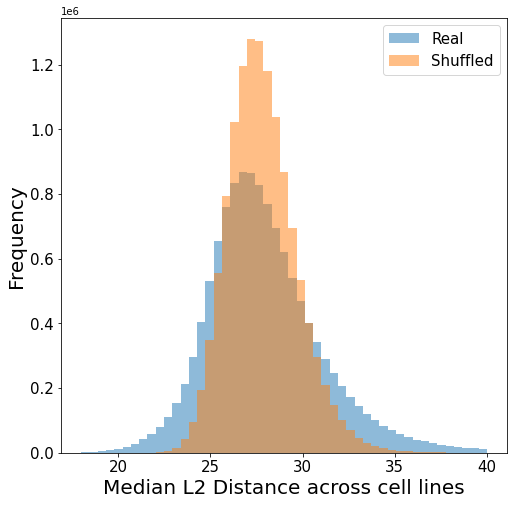

In [8]:
fig, ax = plt.subplots(1, figsize = (8,8))

med_dists = np.median(dists['real'], axis = 0)
indices = np.triu_indices(med_dists.shape[0], 1)
vals = med_dists[indices]
xlim = [18,40]
ax.hist(vals[vals!=0], bins = np.linspace(xlim[0],xlim[1],50),alpha = 0.5, label = 'Real')

med_dists_shuffled = np.median(dists['shuffled'], axis = 0)
indices = np.triu_indices(med_dists_shuffled.shape[0], 1)
vals = med_dists_shuffled[indices]
ax.hist(vals[vals!=0], bins = np.linspace(xlim[0],xlim[1],50),alpha = 0.5, label = 'Shuffled')

ax.set_xlabel("Median L2 Distance across cell lines", size = 20)
ax.set_ylabel("Frequency", size = 20)
ax.tick_params(labelsize = 15)
ax.legend(prop = {'size':15})



The existence of a heavy lower tail here in the real data is good - it means that at least compared to random data, LINCS contains KO pairs which are consistently 'close'

### A measure of neighbourhood consistency
What we really want to get a sense of is how consistent the local neighbourhood is around some KO. To do so i'll essentially ask:

    "For some KO A, what's the smallest value of k such that their exists at least one KO B which is in the k-NN graph of A in at least half of the cell lines"

Or, in maths we can define a consistency measure:

$\Lambda_{i}(f) = min_{k}\bigg\{k\ \bigg|\ \exists j\ s.t. \big[\sum_{c}Id(j \in \mathcal{N}^{c,k}_{i})\big]\geq fC\bigg\}$

Where:
- $C$ is our number of cell lines
- $Id()$ is just a counting function
- $\mathcal{N}^{c,k}_{i}$ is the $k$ nearest neighbourhood of KO $i$ in cell line $c$
- $f \in [0,1]$



In [70]:
#For the full dataset this could take some time so i'll load up some cut down data
num_KOs = 5002
lincs_cut, lincs_genes_cut, _ = get_lincs()
lincs_cut, lincs_genes_cut = lincs_cut[:num_KOs,:,:], lincs_genes_cut[:num_KOs]

lincs_cut_shuffled = np.copy(lincs_cut)
for cell_line in np.arange(lincs_cut.shape[-1]):
    order = np.arange(lincs_cut.shape[0])
    np.random.shuffle(order)
    lincs_cut_shuffled[:,:,cell_line] = lincs_cut[order,:,cell_line] 

Pulling folder parsed/literature_datasets/L1000


In [72]:
lincs_l2_consistency = {}
lincs_l2_consistency['real'] = get_consistency(lincs_cut, f = 0.8, minpartners=3)
lincs_l2_consistency['shuffled'] = get_consistency(lincs_cut_shuffled, f = 0.8, minpartners=3)


Text(0.5, 0, 'Consistency measure')

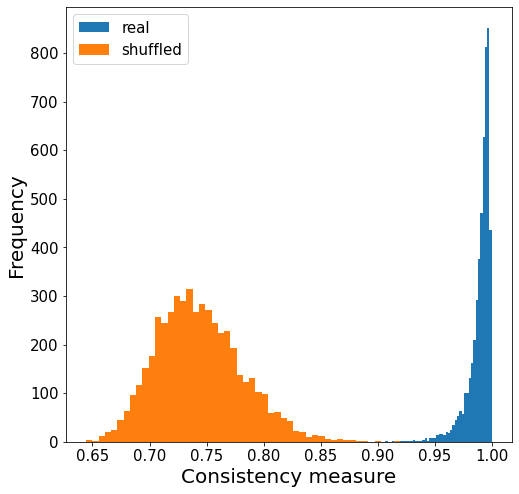

In [73]:
fig, ax = plt.subplots(1, figsize = (8,8))

for name in ['real','shuffled']:
    ax.hist(lincs_l2_consistency[name], bins = 50, label = name)
ax.legend(prop = {'size': 15})
ax.tick_params(labelsize = 15)
ax.set_ylabel("Frequency", size = 20)
ax.set_xlabel("Consistency measure", size = 20)